<a href="https://colab.research.google.com/github/srabhine/SSL/blob/main/TP_SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

[Course Webpage](https://sites.google.com/view/berkeley-cs294-158-sp20/home)

[1] Pathak, Deepak, et al. "Context encoders: Feature learning by inpainting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[2] Gidaris, Spyros, Praveer Singh, and Nikos Komodakis. "Unsupervised representation learning by predicting image rotations." arXiv preprint arXiv:1803.07728 (2018).

[3] Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." arXiv preprint arXiv:2002.05709 (2020).

[4] Noroozi, Mehdi, and Paolo Favaro. "Unsupervised learning of visual representations by solving jigsaw puzzles." European Conference on Computer Vision. Springer, Cham, 2016.

[5] Wang, Xiaolong, Allan Jabri, and Alexei A. Efros. "Learning correspondence from the cycle-consistency of time." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019.

[6] Oord, Aaron van den, Yazhe Li, and Oriol Vinyals. "Representation learning with contrastive predictive coding." arXiv preprint arXiv:1807.03748 (2018).

[7] Hénaff, Olivier J., et al. "Data-efficient image recognition with contrastive predictive coding." arXiv preprint arXiv:1905.09272 (2019).

[8] Tian, Yonglong, Dilip Krishnan, and Phillip Isola. "Contrastive multiview coding." arXiv preprint arXiv:1906.05849 (2019).

[9] He, Kaiming, et al. "Momentum contrast for unsupervised visual representation learning." arXiv preprint arXiv:1911.05722 (2019).

[10] Doersch, Carl, Abhinav Gupta, and Alexei A. Efros. "Unsupervised visual representation learning by context prediction." Proceedings of the IEEE International Conference on Computer Vision. 2015.

[11] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [1]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/wilson1yan/cs294-158-ssl
!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 611 (delta 115), reused 119 (delta 53), pack-reused 422
Receiving objects: 100% (611/611), 3.11 MiB | 22.78 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul-helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25298 sha256=33ec12a92f549d09ac9d4e8ae821cd40ea71954b72bead539ff9e9eee6d27478
  Stored in directory: /root/.cache/pip/wheels/e3/df/97/281e32d717214451862e0e558746de423b9ef530b7376421e2
Successfully built deepul-helper
  Attempting uninstall: deepul-helper
    Found existing installation: deepul-helper 0.1.0
    Uninstalling deepul-helper-0.1.0:
      Successfully uninstalled deepul-helper-0.1.0


Run the cells below to download the necessary pretrained models. It should take a few minutes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -qq '/content/drive/MyDrive/data.zip' -d '/content/cs294-158-ssl'

In [4]:
!unzip -qq '/content/drive/MyDrive/results.zip' -d '/content/cs294-158-ssl'

The models and demos shown were pre-trained. The code used for all the demos can be found in the github repo [here](https://github.com/wilson1yan/cs294-158-ssl). Follow the README to train models on CIFAR10 or ImageNet.

# Self-Supervised Learning Tasks
Self-supervised learning is a rapidly growing field, its success largely accelerated by growing compute and the vast amount of unlabeled data available for training. The hope is that by pretraining on specially designed self-supervised tasks, the models would be able to learn semantically meaningful representations to be used for downstream tasks. In the following demos, we will look at a few examples of these self-supervised tasks.

In [5]:
from deepul_helper.demos import load_model_and_data, display_nearest_neighbors, show_context_encoder_inpainting

%matplotlib inline

In [6]:
from deepul_helper.demos import evaluate_classifier
def evaluate_accuracy(model, linear_classifier, train_loader, test_loader):
    train_acc1, train_acc5 = evaluate_classifier(model, linear_classifier, train_loader)
    test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, test_loader)

    train_acc_list = [train_acc1, train_acc5]
    test_acc_list = [test_acc1, test_acc5]

    print('Train Set')
    print(f'Top 1 Accuracy: {train_acc1}, Top 5 Accuracy: {train_acc5}\n')
    print('Test Set')
    print(f'Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n')
    return train_acc_list,test_acc_list

## Demo 1: Context Encoder [[1]](https://arxiv.org/abs/1604.07379)

The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$
However, this demo does not use the adversarial portion of the loss.

### Example Code

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes):
        super().__init__()
        input_channels = 3

        self.latent_dim = 4000

        # Encodes the masked image
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon


### Inpainting Examples
For each pair of images, the left image is the masked input and the right the inpainted reconstruction.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


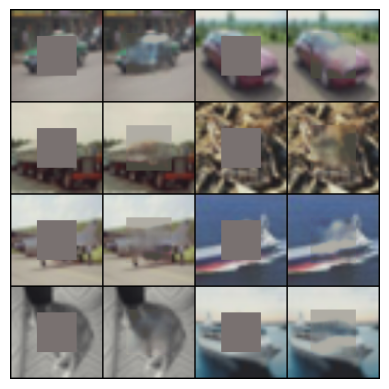

In [8]:
show_context_encoder_inpainting()

### Linear Classification
By design the model architecture is an encoder -> decoder module. We can use the bottleneck layer as our learned representation. Below, we show linear classification accuracy results on CIFAR10 using the learned representations.

In [9]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29



([53.236, 94.094], [45.77, 90.29])

### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


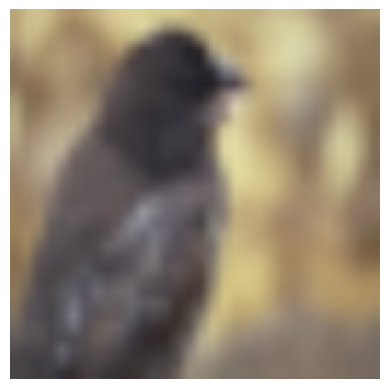

Top 16 Nearest Neighbors (in latent space)


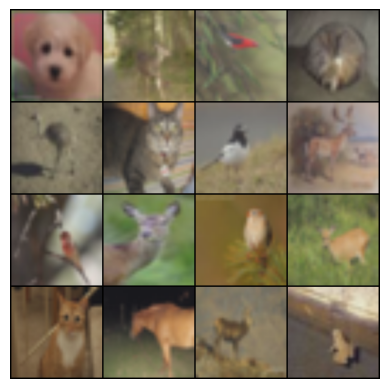

Image 2


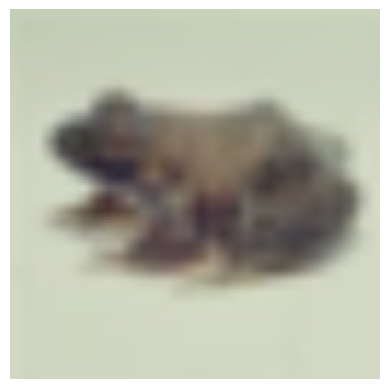

Top 16 Nearest Neighbors (in latent space)


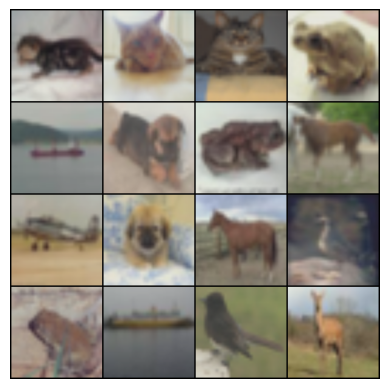

Image 3


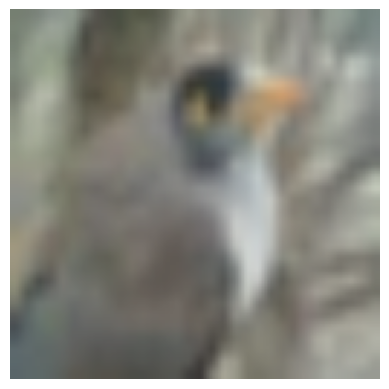

Top 16 Nearest Neighbors (in latent space)


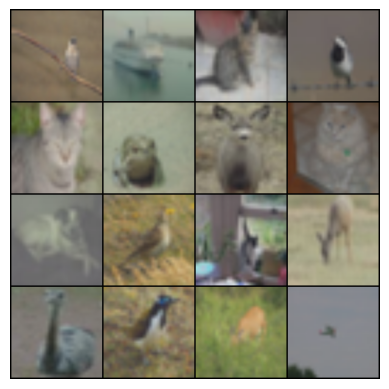

Image 4


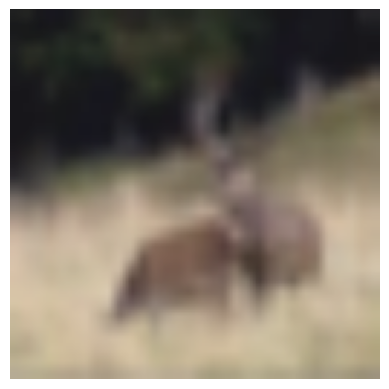

Top 16 Nearest Neighbors (in latent space)


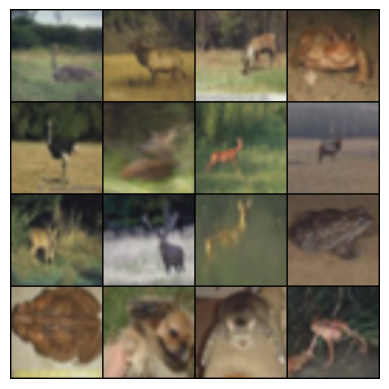

In [10]:
display_nearest_neighbors('context_encoder', model, test_loader)

## Demo 2: Rotation Prediction [[2]](https://arxiv.org/abs/1803.07728)

In this paper, the authors show that accurately predicting the degrees of rotation in images is a self-supervised learning task that learns good representations for downstream tasks.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

More specifically, the authors showed that training a common CNN architecture (AlexNet, ResNet) on the rotation task learns semantically interpretable convolutional masks similar to those learned in supervised learning.

### Example Code

In [11]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, dataset, n_classes):
        super().__init__()
        if dataset == 'cifar10':
            self.model = NetworkInNetwork()
            self.latent_dim = 192 * 8 * 8
            self.feat_layer = 'conv2'
        elif 'imagenet' in dataset:
            self.model = AlexNet()
            self.latent_dim = 256 * 13 * 13
            self.feat_layer = 'conv5'
        else:
            raise Exception('Unsupported dataset:', dataset)
        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        if self.dataset == 'cifar10':
            classifier = nn.Sequential(
                Flatten(),
                nn.BatchNorm1d(self.latent_dim, affine=False),
                nn.Linear(self.latent_dim, self.n_classes)
            )
        elif 'imagenet' in self.dataset:
            classifier = nn.Sequential(
                nn.AdaptiveMaxPool2d((6, 6)),
                nn.BatchNorm2d(256, affine=False),
                Flatten(),
                nn.Linear(256 * 6 * 6, self.n_classes)
            )
        else:
            raise Exception('Unsupported dataset:', dataset)
        return classifier

    def forward(self, images):
        batch_size = images.shape[0]
        images, targets = self._preprocess(images)
        targets = targets.to(images.get_device())

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size)
        targets = targets.view(batch_size, 4).transpose(0, 1)
        targets = targets.contiguous().view(-1)
        return images_batch, targets

### Linear Classification
We can use the feature maps in the later convolutional layers of the pretrained model as our learned representation for linear classification.

In [12]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('rotation')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 79.464, Top 5 Accuracy: 99.116

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12



([79.464, 99.116], [79.91, 99.12])

### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


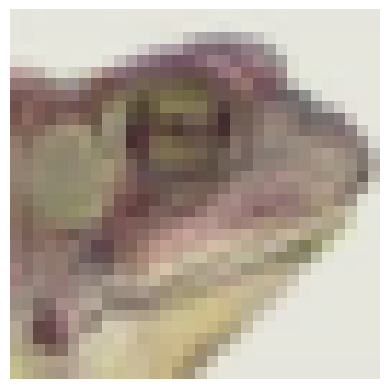

Top 16 Nearest Neighbors (in latent space)


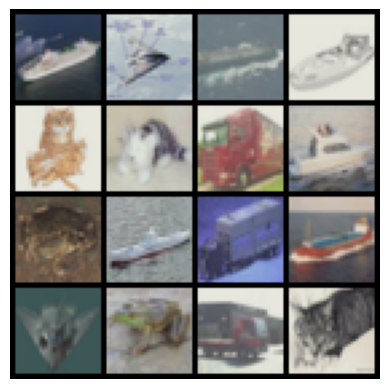

Image 2


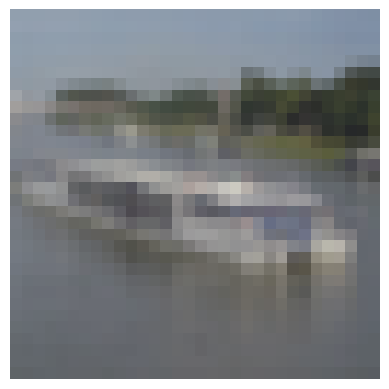

Top 16 Nearest Neighbors (in latent space)


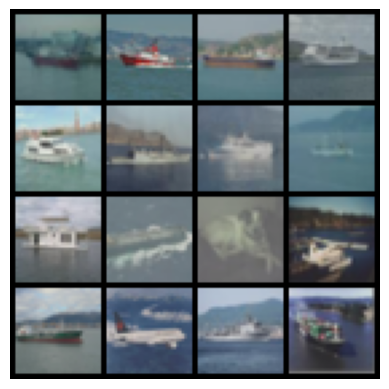

Image 3


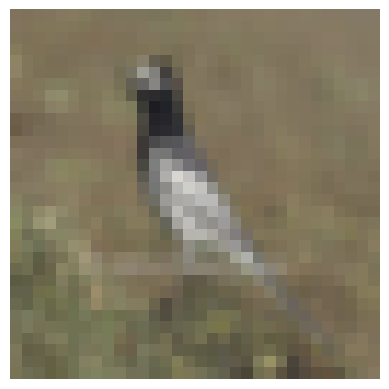

Top 16 Nearest Neighbors (in latent space)


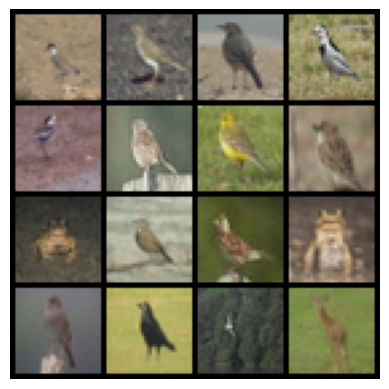

Image 4


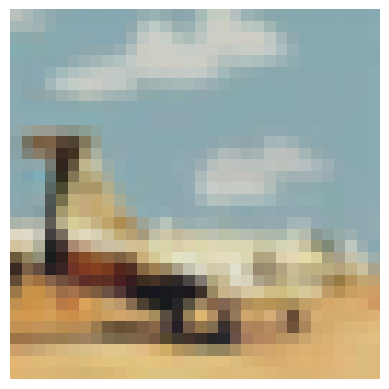

Top 16 Nearest Neighbors (in latent space)


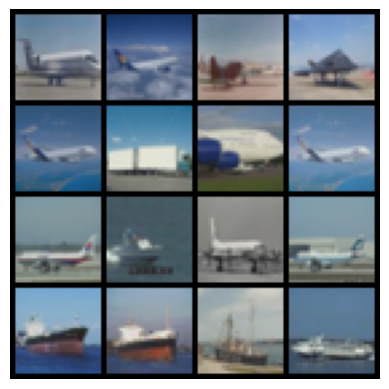

In [13]:
display_nearest_neighbors('rotation', model, test_loader)

## Demo 3: SimCLR [[3]](https://arxiv.org/abs/2002.05709)

SimCLR is a contrastive learning framework to learn strong visual representations. An image $x$ is processed using data augmentation to produce two variants $x_i$ and $x_j$ which are both fed into encoder $f$ (a CNN) and projection head $g$ (a small MLP). The models optimize a contrastive loss to maximally align projected latents $z_i, z_j$. We consider $x_i, x_j$ as a positive pair, and any other $x_i, x_k$ pairs (i.e. different images in the same batch) are negative pairs. A visual diagram of the training procedure is shown below (from the paper).

![](https://drive.google.com/uc?id=1XW1uIkUTMSa0DZncivSYXzM5gA5FIhF6)

More formally, the loss between positive example $z_i, z_j$ is:
$$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = z_i^Tz_j / (\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert)$. The loss function can also be interpreted as a standard cross entropy loss to classify positive samples where logits are constructed using a given similarity function.

Note: A common idea in contrastive learning methods is that a larger batch means more negative samples. Therefore, these methods usually benefit the most from large-batch learning compared to other self-supervised learning tasks.

### Example Code

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deepul_helper.resnet import resnet_v1
from deepul_helper.batch_norm import SyncBatchNorm, BatchNorm1d

# Some code adapted from https://github.com/sthalles/SimCLR
class SimCLR(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes, dist=None):
        super().__init__()
        self.temperature = 0.5
        self.projection_dim = 128

        if dataset == 'cifar10':
            resnet = resnet_v1((3, 32, 32), 50, 1, cifar_stem=True)
            resnet = SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048
        elif 'imagenet' in dataset:
            resnet = resnet_v1((3, 128, 128), 50, 1, cifar_stem=False)
            if dist is not None:
                resnet = nn.SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim, center=False)
        )

        self.dataset = dataset
        self.n_classes = n_classes
        self.dist = dist

    def construct_classifier(self):
        return nn.Sequential(nn.Linear(self.latent_dim, self.n_classes))

    def forward(self, images):
        n = images[0].shape[0]
        xi, xj = images
        hi, hj = self.encode(xi), self.encode(xj) # (N, latent_dim)
        zi, zj = self.proj(hi), self.proj(hj) # (N, projection_dim)
        zi, zj = F.normalize(zi), F.normalize(zj)

        # Each training example has 2N - 2 negative samples
        # 2N total samples, but exclude the current and positive sample

        if self.dist is None:
            zis = [zi]
            zjs = [zj]
        else:
            zis = [torch.zeros_like(zi) for _ in range(self.dist.get_world_size())]
            zjs = [torch.zeros_like(zj) for _ in range(self.dist.get_world_size())]

            self.dist.all_gather(zis, zi)
            self.dist.all_gather(zjs, zj)

        z1 = torch.cat((zi, zj), dim=0) # (2N, projection_dim)
        z2 = torch.cat(zis + zjs, dim=0) # (2N * n_gpus, projection_dim)

        sim_matrix = torch.mm(z1, z2.t()) # (2N, 2N * n_gpus)
        sim_matrix = sim_matrix / self.temperature
        # Mask out same-sample terms
        n_gpus = 1 if self.dist is None else self.dist.get_world_size()
        rank = 0 if self.dist is None else self.dist.get_rank()
        sim_matrix[torch.arange(n), torch.arange(rank*n, (rank+1)*n)]  = -float('inf')
        sim_matrix[torch.arange(n, 2*n), torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n)] = -float('inf')

        targets = torch.cat((torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n),
                             torch.arange(rank*n, (rank+1)*n)), dim=0)
        targets = targets.to(sim_matrix.get_device()).long()

        loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
        loss = loss / n
        return dict(Loss=loss), hi

    def encode(self, images):
        return self.resnet(images[0])

    def get_features(self, images):
        return self.resnet.get_features(images)


### Linear Classification
We can use the encoded vector $h_i$ as our latent representation.

In [15]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('simclr')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 90.042, Top 5 Accuracy: 99.486

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



([90.042, 99.486], [92.84, 99.86])

### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


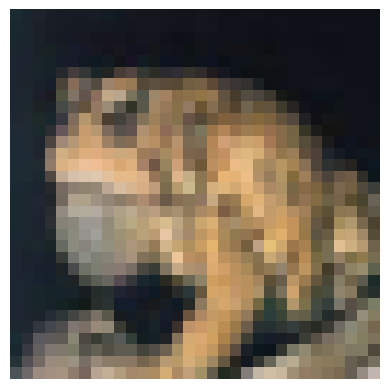

Top 16 Nearest Neighbors (in latent space)


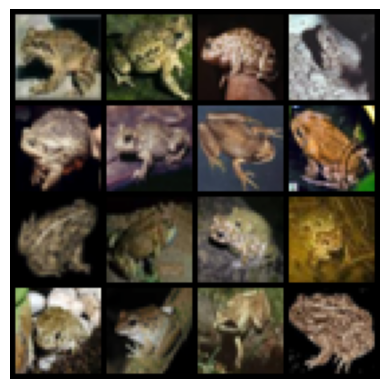

Image 2


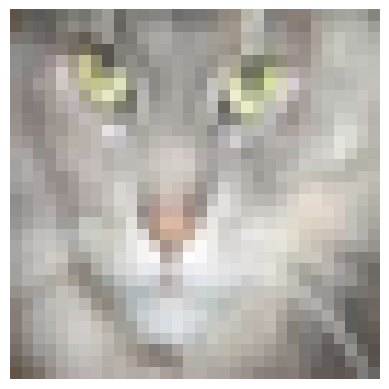

Top 16 Nearest Neighbors (in latent space)


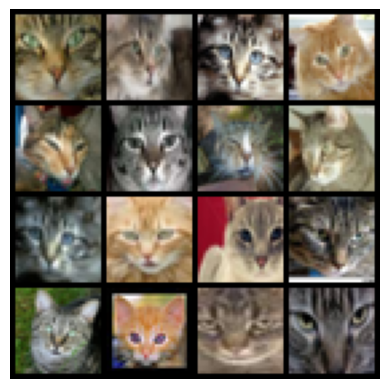

Image 3


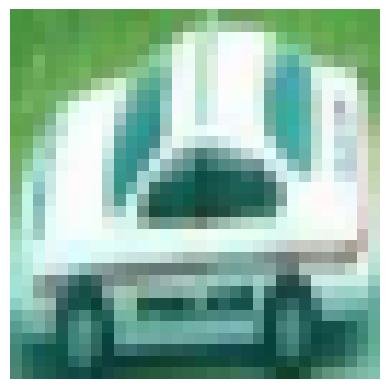

Top 16 Nearest Neighbors (in latent space)


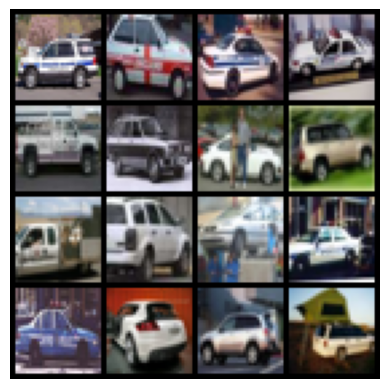

Image 4


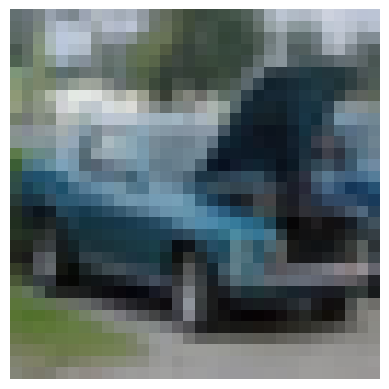

Top 16 Nearest Neighbors (in latent space)


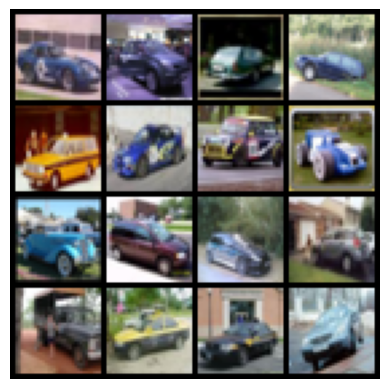

In [16]:
display_nearest_neighbors('simclr', model, test_loader)

## Other Tasks
In addition to the above tasks, prior work has also investigated other self-superivsed tasks such as solving jigsaw puzzles [[4]](https://arxiv.org/abs/1603.09246), cycle-consistency [[5]](https://arxiv.org/abs/1903.07593), contrastive learning [[6]](https://arxiv.org/abs/1807.03748)[[7]](https://arxiv.org/abs/1905.09272)[[8]](https://arxiv.org/abs/1906.05849)[[9]](https://arxiv.org/abs/1911.05722), and patch prediction [[10]](https://arxiv.org/abs/1505.05192). See [here](https://github.com/jason718/awesome-self-supervised-learning) for a great resource on more self-supervised learning papers.

# Demo 4: Using Representations for Downstream Tasks

After pretraining a model on a self-supervised learning task, we can use it for other downstream tasks. In this demo, we use the pre-trained ResNet50 backbone from training SimCLR on a subset of ImageNet to learn a semantic segmentation model on Pascal VOC 2012. We use a simple U-Net [[11]](https://arxiv.org/abs/1505.04597) architecture with skip connections across feature maps between the SimCLR encoder and learned upsampling decoder. We do not fine-tune the SimCLR ResNet50 backbone, and only optimize the upsampling portion.

![](https://drive.google.com/uc?id=19dxxcwof0IA0jyv0VCl4rnZZf3ajA22s)

The training script can be found in `train_segmentation.py` [here](https://github.com/wilson1yan/cs294-158-ssl/blob/master/train_segmentation.py).

## Example Code

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.resnet import NormReLU

class SegmentationModel(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, n_classes):
        super().__init__()

        decoder_channels = (512, 256, 128, 64, 32)
        encoder_channels = (2048, 1024, 512, 256, 64) # Starting from head (resnet 50)

        # Construct decoder blocks
        in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.dec_blocks = nn.ModuleList(blocks)

        # Segmentation head for output prediction
        self.seg_head = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=3, padding=1)

    def forward(self, features, targets):
        features = features[1:] # remove first skip with same spatial resolution
        features = features[::-1] # reverse channels to start from head of encoder

        skips = features[1:]
        x = features[0]
        for i, decoder_block in enumerate(self.dec_blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        logits = self.seg_head(x)
        loss = F.cross_entropy(logits, targets)

        return dict(Loss=loss), logits


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels,
                      kernel_size=3, padding=1),
            NormReLU((out_channels, None, None)), # only care about channel dim for BN
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            NormReLU((out_channels, None, None))
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

## Segmentation Results
Below, we show a random subset of segmentations from the trained model. Every set of 3 images consists of the original image, the labeled segmentation, and the predicted segmentation.

Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012
Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012


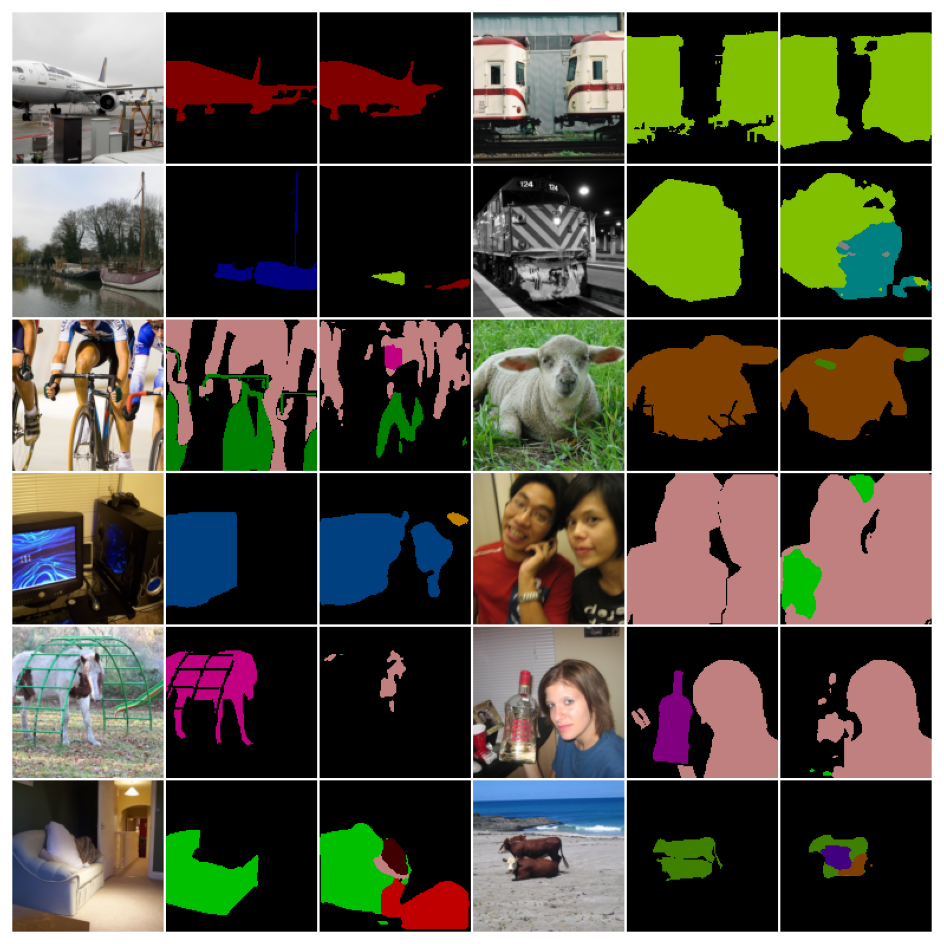

In [18]:
from deepul_helper.demos import show_segmentation
show_segmentation()

# Demo 5: Avoiding Trivial Representations in Self-Supervised Tasks

When designing a self-supervised learning task, it is important to make sure that no trivial solutions exists. In general, a learned solution is trivial if the model is able to successfully complete its task by taking advantage of low-level features. As a result, it doesn't learn a good representation so downstream performance is bad.

For example, in the jigsaw [[4]](https://arxiv.org/abs/1603.09246) task, a model can "cheat" by just looking at the boundary textures of the jigsaw pieces, or following and matching straight lines across different pieces. These issues can generally be fixed by ranndom cropping, shifting, and spacially jittering.

We look at two other less obvious aspects of images that may reduce performance.

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point.
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

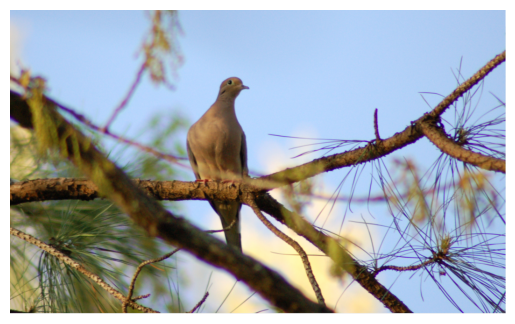

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# You can see some chromatic aberration in the purple fringes around the branches

image = Image.open('sample_images/chrom_ab_demo.png')
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

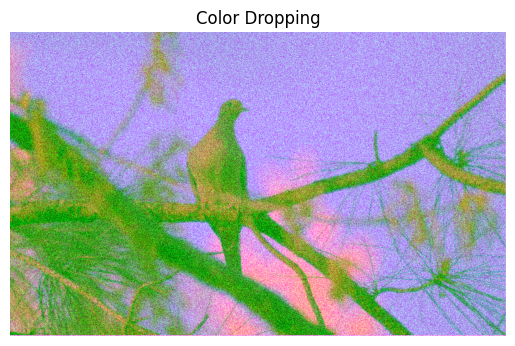

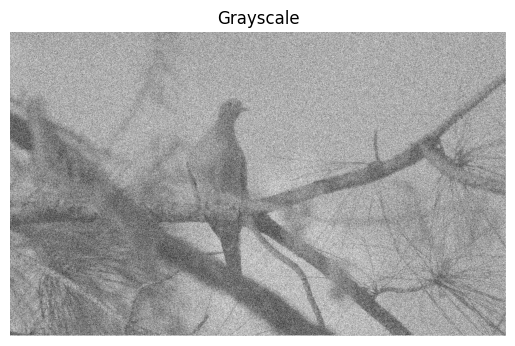

In [20]:
import numpy as np

# Color Dropping
# We will drop all channels except R
image_cpy = image.copy()
pixels = image_cpy.load()

arr = np.array(image_cpy)
std_R = np.std(arr[:, :, 0])
mean_G, mean_B = np.mean(arr[:, :, 1]), np.mean(arr[:, :, 2])

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j] # (R, G, B, A)
    R, A = p[0], p[3]
    G = int(np.random.randn() * std_R + mean_G)
    B = int(np.random.randn() * std_R + mean_B)
    pixels[i, j] = (R, G, p[2], p[3])

plt.figure()
plt.title('Color Dropping')
plt.axis('off')
plt.imshow(image_cpy)
plt.show()

# Grayscale
image_cpy2 = image.copy()
pixels2 = image_cpy2.load()

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j]
    G = int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2])
    pixels2[i, j] = (G, G, G, 255)

plt.figure()
plt.title('Grayscale')
plt.axis('off')
plt.imshow(image_cpy2)
plt.show()

## Color Intensity Histograms

In the SimCLR paper, the authors show that the histogram of color intensities of different patches within the same image have very similar histograms, which may degrade training by encouraging models to look at low-level (pixel intensity) features to solve self-supervised tasks that involve matching positive patches of the same image.

Below, we run a similar demo to what was demonstrated in the paper

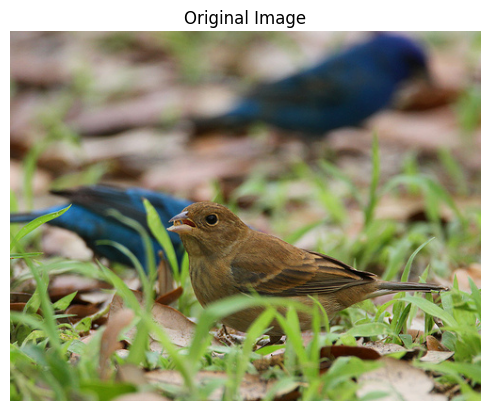

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

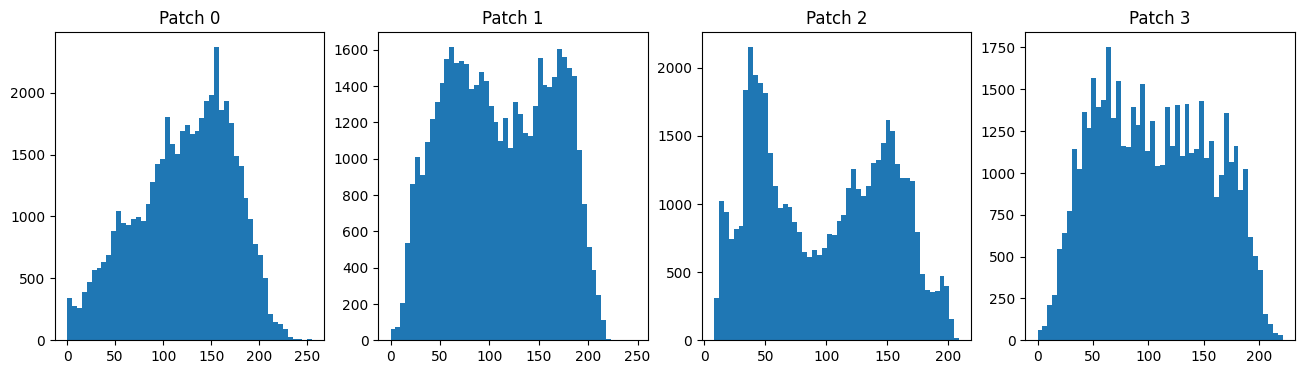

In [22]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Now we apply color jittering to mitigate this effect

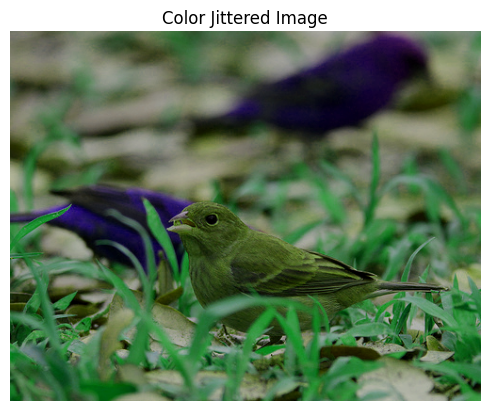

In [23]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
jitter_img = color_jitter(image)

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

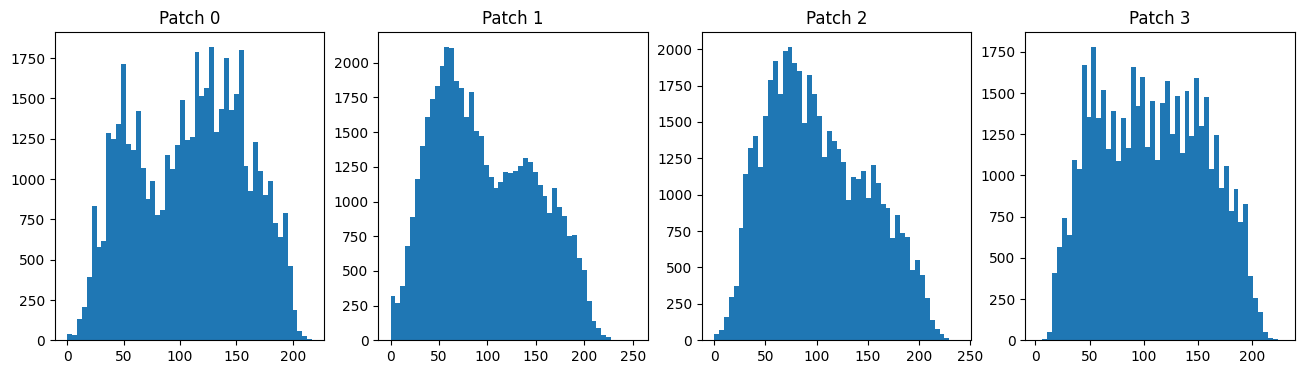

In [24]:
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Plot accuracy

In [25]:
model_con, linear_classifier_con, train_loader_con, test_loader_con = load_model_and_data('context_encoder')
encoder = evaluate_accuracy(model_con, linear_classifier_con, train_loader_con, test_loader_con)

model_rot, linear_classifier_rot, train_loader_rot, test_loader_rot = load_model_and_data('rotation')
rotation = evaluate_accuracy(model_rot, linear_classifier_rot, train_loader_rot, test_loader_rot)

model_sim, linear_classifier_sim, train_loader_sim, test_loader_sim = load_model_and_data('simclr')
simclr = evaluate_accuracy(model_sim, linear_classifier_sim, train_loader_sim, test_loader_sim)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 79.584, Top 5 Accuracy: 99.102

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 90.166, Top 5 Accuracy: 99.506

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29

Train Set
Top 1 Accuracy: 79.558, Top 5 Accuracy: 99.074

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12

Train Set
Top 1 Accuracy: 90.24, Top 5 Accuracy: 99.46

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



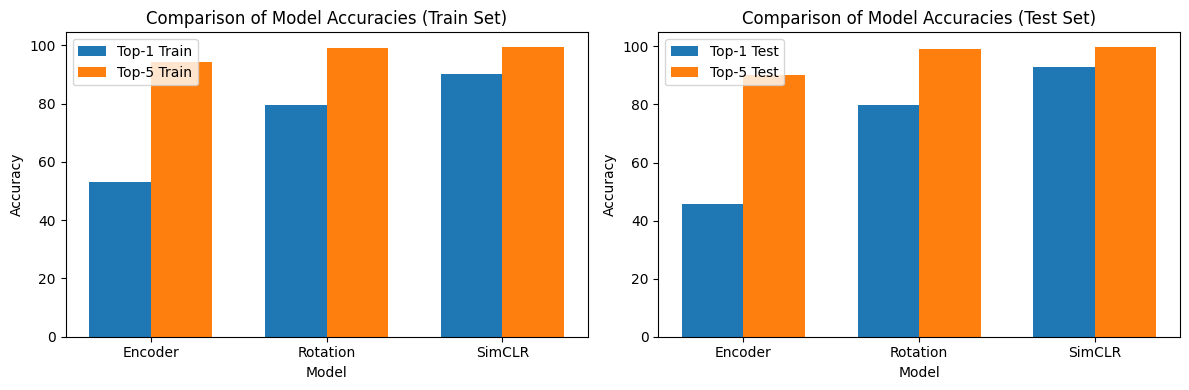

In [26]:
import matplotlib.pyplot as plt
import numpy as np

encoder_train_acc, encoder_test_acc = evaluate_accuracy(model_con, linear_classifier_con, train_loader_con, test_loader_con)
rotation_train_acc, rotation_test_acc = evaluate_accuracy(model_rot, linear_classifier_rot, train_loader_rot, test_loader_rot)
simclr_train_acc, simclr_test_acc = evaluate_accuracy(model_sim, linear_classifier_sim, train_loader_sim, test_loader_sim)


model_names = ['Encoder', 'Rotation', 'SimCLR']

test_accs_top1 = [encoder_test_acc[0], rotation_test_acc[0], simclr_test_acc[0]]
test_accs_top5 = [encoder_test_acc[1], rotation_test_acc[1], simclr_test_acc[1]]

train_accs_top1 = [encoder_train_acc[0], rotation_train_acc[0], simclr_train_acc[0]]
train_accs_top5 = [encoder_train_acc[1], rotation_train_acc[1], simclr_train_acc[1]]

bar_width = 0.35


index = np.arange(len(model_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(index - bar_width/2, train_accs_top1, bar_width, label='Top-1 Train')
ax1.bar(index + bar_width/2, train_accs_top5, bar_width, label='Top-5 Train')

ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_title('Comparison of Model Accuracies (Train Set)')
ax1.set_xticks(index)
ax1.set_xticklabels(model_names)
ax1.legend()
ax2.bar(index - bar_width/2, test_accs_top1, bar_width, label='Top-1 Test')
ax2.bar(index + bar_width/2, test_accs_top5, bar_width, label='Top-5 Test')

ax2.set_xlabel('Model')
ax2.set_ylabel('Accuracy')
ax2.set_title('Comparison of Model Accuracies (Test Set)')
ax2.set_xticks(index)
ax2.set_xticklabels(model_names)
ax2.legend()

plt.tight_layout()

plt.show()


In [27]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sammyrabhine","key":"bb13698cda6103ebf9ae082ab0aaa491"}'}

In [28]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
! kaggle datasets download ambityga/imagenet100 -p 'data/imagenet/'

100% 16.1G/16.1G [04:49<00:00, 56.2MB/s]
100% 16.1G/16.1G [04:49<00:00, 59.8MB/s]


In [30]:
! unzip 'data/imagenet/imagenet100.zip' -d 'data/imagenet/'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00000293.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00002138.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00003014.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00006697.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00007197.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00009111.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00009191.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00009346.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00009379.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00009396.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00010306.JPEG  
  inflating: data/imagenet/val.X/n01440764/ILSVRC2012_val_00011233.JPEG  
  inflating: data/imagenet/val.X/n

In [33]:
!python create_imagenet_subset.py 10

Creating a subset of ImageNet with 10 classes
100% 10/10 [00:32<00:00,  3.24s/it]


In [36]:
!rm -r /content/cs294-158-ssl/data/pascalvoc2012
!rm -r /content/cs294-158-ssl/data/imagenet/imagenet100.zip

rm: cannot remove '/content/cs294-158-ssl/data/pascalvoc2012': No such file or directory


In [39]:
!pip install warmup_scheduler
! CUDA_VISIBLE_DEVICES=0 python train_self_supervised_task.py -d imagenet10 -t rotation -b 64 -e 10 -o adam --lr 0.3 -w 1e-6

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [40]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('rotation',"imagenet10")
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 27.223076914860652, Top 5 Accuracy: 76.91538460129958

Test Set
Top 1 Accuracy: 28.799999877929686, Top 5 Accuracy: 77.19999981689453



([27.223076914860652, 76.91538460129958],
 [28.799999877929686, 77.19999981689453])

In [41]:
! CUDA_VISIBLE_DEVICES=0 python train_self_supervised_task.py -d imagenet10 -t simclr -b 64 -e 10 -o adam --lr 0.3 -w 1e-6

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [42]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('simclr',"imagenet10")
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 29.26153844980093, Top 5 Accuracy: 79.82307689021184

Test Set
Top 1 Accuracy: 33.59999957275391, Top 5 Accuracy: 84.60000048828125



([29.26153844980093, 79.82307689021184],
 [33.59999957275391, 84.60000048828125])

In [43]:
!pip install warmup_scheduler
! CUDA_VISIBLE_DEVICES=0 python train_self_supervised_task.py -d imagenet10 -t context_encoder -b 64 -e 10 -o adam --lr 0.3 -w 1e-6

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [44]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder',"imagenet10")
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 10.423076917208158, Top 5 Accuracy: 50.207692298302284

Test Set
Top 1 Accuracy: 8.399999973297119, Top 5 Accuracy: 47.000000030517576



([10.423076917208158, 50.207692298302284],
 [8.399999973297119, 47.000000030517576])

In [45]:
import os
import random
import shutil

val_directory = "/content/cs294-158-ssl/data/imagenet10/train"
test_directory = "/content/cs294-158-ssl/data/imagenet10/test"


classes = os.listdir(val_directory)
for classe in classes:
    classe_path = os.path.join(val_directory, classe)
    if os.path.isdir(classe_path):
        images = os.listdir(classe_path)
        if len(images) >= 2:

            random.shuffle(images)
            split_point = len(images) // 2
            test_images = images[:split_point]
            for image in test_images:
                source_path = os.path.join(classe_path, image)
                destination_path = os.path.join(test_directory, classe, image)
                os.makedirs(os.path.dirname(destination_path), exist_ok=True)
                shutil.move(source_path, destination_path)

print("Done")


Done


Creating dataset for training and validation

In [46]:
class Config():
  ROOT = 'data/imagenet10'
  TRAIN_PATH = 'data/imagenet10/train'
  VAL_PATH = 'data/imagenet10/val'
  TEST_PATH = 'data/imagenet10/test'
  subset_data = 1000
  patch_dim = 15
  gap = 3
  batch_size = 128
  num_epochs = 10
  lr = 0.001

In [47]:
import pandas as pd
import os

train_files = []
for subdir in os.listdir('data/imagenet10/train'):
    for file in os.listdir(os.path.join('data/imagenet10/train', subdir)):
        train_files.append(os.path.join('data/imagenet10/train', subdir, file))


df_trn = pd.DataFrame({'image_path': train_files})

df_trn['class_label'] = df_trn['image_path'].apply(lambda x: x.split('/')[-1].split('_')[0])

df_trn.to_csv('imagenet10_train.csv', index=False)

In [48]:
df_trn['image_path']

0       data/imagenet10/train/n01950731/n01950731_6403...
1       data/imagenet10/train/n01950731/n01950731_1411...
2       data/imagenet10/train/n01950731/n01950731_494....
3       data/imagenet10/train/n01950731/n01950731_2234...
4       data/imagenet10/train/n01950731/n01950731_2862...
                              ...                        
6495    data/imagenet10/train/n01484850/n01484850_1738...
6496    data/imagenet10/train/n01484850/n01484850_1469...
6497    data/imagenet10/train/n01484850/n01484850_1133...
6498    data/imagenet10/train/n01484850/n01484850_1866...
6499    data/imagenet10/train/n01484850/n01484850_4965...
Name: image_path, Length: 6500, dtype: object

In [49]:
import pandas as pd
import os

val_files = []
for subdir in os.listdir('data/imagenet10/val'):
    for file in os.listdir(os.path.join('data/imagenet10/val', subdir)):
        val_files.append(os.path.join('data/imagenet10/val', subdir, file))

df_val = pd.DataFrame({'image_path': val_files})

df_val['class_label'] = df_trn['image_path'].apply(lambda x: x.split('/')[-1].split('_')[0])

df_val.to_csv('imagenet10_val.csv', index=False)

In [50]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets

import torchvision
from torchvision import transforms
from torchvision import models

import torch.nn.functional as F
import torchvision.transforms.functional as TF

import albumentations

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

np.random.seed(108)

plt.style.use('default')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

visualize = False

class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform

    if validate:
      self.train_data = df.values
    else:
      self.train_data = df.values

  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]

    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    random_patch_label = loc

    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)

  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image,
                                                                               self.patch_dim,
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))

        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    # Dropped color channels 2 and 3 and replaced with gaussian noise(std ~1/100 of the std of the remaining channel)
    #uniform_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #uniform_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #random_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))
    #random_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))

    random_patch_label = np.array(random_patch_label).astype(np.int64)

    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label



##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = MyDataset(Config.patch_dim, Config.gap, df_trn['image_path'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset,
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          # num_workers=Config.num_workers
                                          )


valdataset = MyDataset(Config.patch_dim, Config.gap, df_val['image_path'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

In [51]:

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()


##############################
# Visualizing training dataset
##############################
"""
Args:
    tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
Returns:
    Tensor: Normalized image.
"""
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

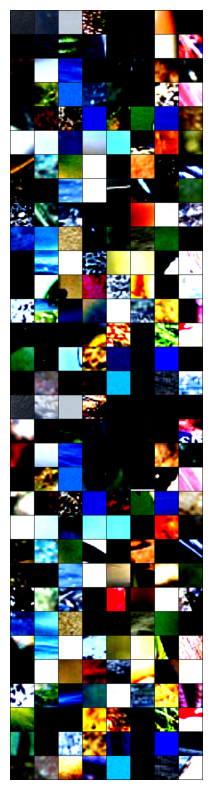

Labels: [1 2 6 0 0 3 2 7 4 7 6 5 1 4 7 6 2 7 3 6 3 4 5 3 1 1 6 7 6 6 3 7 6 6 1 3 7
 7 0 0 2 2 0 1 0 1 4 3 5 1 0 6 7 5 1 5 0 5 4 6 2 5 6 3 1 3 6 1 3 5 6 4 1 5
 5 6 5 7 0 7 7 2 2 2 5 7 5 7 2 7 2 1 5 5 2 3 2 0 6 7 0 3 6 6 5 6 6 7 7 7 7
 2 4 2 2 1 0 1 5 6 2 1 0 2 4 4 4 4]


In [52]:
example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

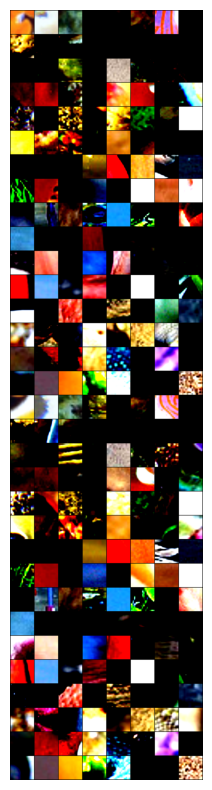

Labels: [6 1 7 7 5 6 7 0 6 7 4 0 0 5 0 6 6 1 5 3 1 1 0 1 1 3 6 5 5 1 2 3 1 4 0 5 3
 3 2 2 5 1 0 6 3 1 3 5 7 0 5 2 5 7 1 6 3 0 6 5 2 3 7 7 5 1 1 3 0 4 6 4 2 0
 7 7 5 1 7 3 5 1 4 6 4 6 7 1 1 4 4 5 0 0 2 4 0 0 3 6 4 4 0 3 4 4 6 1 5 2 1
 3 5 5 2 7 1 2 6 2 7 7 1 4 1 1 0 7]


In [53]:
##############################
# Visualizing validation dataset
##############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')


In [54]:
class AlexNetwork(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNetwork, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),

        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output


  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

model = AlexNetwork().to(device)


In [55]:
#############################################
# Initialized Optimizer, criterion, scheduler
#############################################

#optimizer = optim.Adam(model.parameters(), lr=Config.lr)
optimizer = optim.SGD(model.parameters(), Config.lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='min',
                                           patience=5,
                                           factor=0.3, verbose=True)

In [56]:
############################
# Training/Validation Engine
############################
global_trn_loss = []
global_val_loss = []
# previous_val_loss = 100

for epoch in range(Config.num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
        uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
        loss = criterion(output, random_patch_label)
        loss.backward()
        optimizer.step()

        train_running_loss.append(loss.item())
    else:
        total=0
        correct_top1 = 0
        correct_top5 = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset) / Config.batch_size)):
            uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
            output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
            loss = criterion(output, random_patch_label)
            val_running_loss.append(loss.item())

            _, predicted_top5 = torch.topk(output.data, 5)
            _,predicted_top1 = torch.max(output.data, 1)
            total += random_patch_label.size(0)
            correct_top1 += (predicted_top1 == random_patch_label).sum()
            correct_top5 += torch.sum(predicted_top5 == random_patch_label.view(-1, 1)).item()
          print('Val Progress --- total:{}, correct top-1:{}, correct top-5:{}'.format(total, correct_top1, correct_top5))
          print('Val Accuracy (top-1) of the network on the validation set: {}%'.format(100 * correct_top1 / total))
          print('Val Accuracy (top-5) of the network on the validation set: {}%'.format(100 * correct_top5 / total))

    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    scheduler.step(global_val_loss[-1])

    print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
        epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
        (time.time() - start_time) / 60))

    if epoch % 20 == 0:
      MODEL_SAVE_PATH = f'/content/drive/MyDrive/TPssl/resultats_train/model_{Config.batch_size}_{Config.num_epochs}_{Config.lr}_{Config.subset_data}_{Config.patch_dim}_{Config.gap}.pt'
      torch.save(
        {
            'epoch': Config.num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_trnloss': global_trn_loss,
            'global_valloss': global_val_loss
        }, MODEL_SAVE_PATH)


51it [01:16,  1.51s/it]
4it [00:05,  1.34s/it]


Val Progress --- total:500, correct top-1:57, correct top-5:303
Val Accuracy (top-1) of the network on the validation set: 11.40000057220459%
Val Accuracy (top-5) of the network on the validation set: 60.6%
Epoch [1/10], TRNLoss:2.0834, VALLoss:2.0876, Time:1.37


51it [01:06,  1.30s/it]
4it [00:06,  1.61s/it]


Val Progress --- total:500, correct top-1:58, correct top-5:319
Val Accuracy (top-1) of the network on the validation set: 11.600000381469727%
Val Accuracy (top-5) of the network on the validation set: 63.8%
Epoch [2/10], TRNLoss:2.0840, VALLoss:2.0853, Time:1.22


51it [01:04,  1.26s/it]
4it [00:05,  1.44s/it]


Val Progress --- total:500, correct top-1:79, correct top-5:322
Val Accuracy (top-1) of the network on the validation set: 15.80000114440918%
Val Accuracy (top-5) of the network on the validation set: 64.4%
Epoch [3/10], TRNLoss:2.0834, VALLoss:2.0817, Time:1.17


51it [01:05,  1.28s/it]
4it [00:05,  1.42s/it]


Val Progress --- total:500, correct top-1:63, correct top-5:302
Val Accuracy (top-1) of the network on the validation set: 12.600000381469727%
Val Accuracy (top-5) of the network on the validation set: 60.4%
Epoch [4/10], TRNLoss:2.0828, VALLoss:2.0884, Time:1.18


51it [01:05,  1.29s/it]
4it [00:04,  1.09s/it]


Val Progress --- total:500, correct top-1:57, correct top-5:306
Val Accuracy (top-1) of the network on the validation set: 11.40000057220459%
Val Accuracy (top-5) of the network on the validation set: 61.2%
Epoch [5/10], TRNLoss:2.0819, VALLoss:2.0918, Time:1.17


51it [01:06,  1.30s/it]
4it [00:04,  1.13s/it]


Val Progress --- total:500, correct top-1:55, correct top-5:319
Val Accuracy (top-1) of the network on the validation set: 11.000000953674316%
Val Accuracy (top-5) of the network on the validation set: 63.8%
Epoch [6/10], TRNLoss:2.0827, VALLoss:2.0881, Time:1.18


51it [01:06,  1.30s/it]
4it [00:04,  1.11s/it]


Val Progress --- total:500, correct top-1:70, correct top-5:330
Val Accuracy (top-1) of the network on the validation set: 14.000000953674316%
Val Accuracy (top-5) of the network on the validation set: 66.0%
Epoch [7/10], TRNLoss:2.0809, VALLoss:2.0782, Time:1.18


51it [01:05,  1.29s/it]
4it [00:05,  1.31s/it]


Val Progress --- total:500, correct top-1:73, correct top-5:316
Val Accuracy (top-1) of the network on the validation set: 14.600000381469727%
Val Accuracy (top-5) of the network on the validation set: 63.2%
Epoch [8/10], TRNLoss:2.0813, VALLoss:2.0775, Time:1.18


51it [01:04,  1.27s/it]
4it [00:06,  1.56s/it]


Val Progress --- total:500, correct top-1:76, correct top-5:334
Val Accuracy (top-1) of the network on the validation set: 15.200000762939453%
Val Accuracy (top-5) of the network on the validation set: 66.8%
Epoch [9/10], TRNLoss:2.0817, VALLoss:2.0709, Time:1.19


51it [01:04,  1.26s/it]
4it [00:05,  1.47s/it]

Val Progress --- total:500, correct top-1:89, correct top-5:337
Val Accuracy (top-1) of the network on the validation set: 17.80000114440918%
Val Accuracy (top-5) of the network on the validation set: 67.4%
Epoch [10/10], TRNLoss:2.0800, VALLoss:2.0732, Time:1.17


In [57]:
import os

test_files = []
for subdir in os.listdir('data/imagenet10/test'):
  for file in os.listdir(os.path.join('data/imagenet10/test', subdir)):
    test_files.append(os.path.join('data/imagenet10/test', subdir, file))

df_test = pd.DataFrame({'image_path': test_files})

df_test['class_label'] = df_test['image_path'].apply(lambda x: x.split('/')[-1].split('_')[0])

df_test.to_csv('imagenet10_test.csv', index=False)

In [58]:
df_test.head()

image_path class_label
0  data/imagenet10/test/n01950731/n01950731_3552....   n01950731
1  data/imagenet10/test/n01950731/n01950731_5061....   n01950731
2  data/imagenet10/test/n01950731/n01950731_12928...   n01950731
3  data/imagenet10/test/n01950731/n01950731_9775....   n01950731
4  data/imagenet10/test/n01950731/n01950731_15066...   n01950731

In [59]:
testdataset = MyDataset(Config.patch_dim, Config.gap, df_test['image_path'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
testloader = torch.utils.data.DataLoader(testdataset,
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          # num_workers=Config.num_workers
                                          )

In [60]:
total=0
correct_top1 = 0
correct_top5 = 0
model.eval()
test_running_loss = []
global_test_loss= []
with torch.no_grad():
  for idx, data in tqdm(enumerate(testloader), total=int(len(testdataset) / Config.batch_size)):
    uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
    output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
    loss = criterion(output, random_patch_label)
    test_running_loss.append(loss.item())

    _, predicted_top5 = torch.topk(output.data, 5)
    _,predicted_top1 = torch.max(output.data, 1)
    total += random_patch_label.size(0)
    correct_top1 += (predicted_top1 == random_patch_label).sum()
    correct_top5 += torch.sum(predicted_top5 == random_patch_label.view(-1, 1)).item()
  print('Val Progress --- total:{}, correct top-1:{}, correct top-5:{}'.format(total, correct_top1, correct_top5))
  print('Val Accuracy (top-1) of the network on the test set: {}%'.format(100 * correct_top1 / total))
  print('Val Accuracy (top-5) of the network on the test set: {}%'.format(100 * correct_top5 / total))

global_test_loss.append(sum(test_running_loss) / len(test_running_loss))

scheduler.step(global_test_loss[-1])


51it [01:05,  1.28s/it]

Val Progress --- total:6500, correct top-1:903, correct top-5:4219
Val Accuracy (top-1) of the network on the test set: 13.89230728149414%
Val Accuracy (top-5) of the network on the test set: 64.9076923076923%


### CIFAR 10


In [4]:
from tensorflow.keras import datasets

In [5]:
(X_train,y_train),(X_test,y_test)=datasets.cifar10.load_data()

test_size = len(X_test)

# Divide the test set into two equal parts
split_index = test_size // 2

X_val, y_val = X_test[:split_index], y_test[:split_index]
X_test, y_test = X_test[split_index:], y_test[split_index:]

170498071/170498071 [==============================] - 14s 0us/step


In [6]:
import pandas as pd

train_data = pd.DataFrame({'Image': [img for img in X_train], 'Label': [label[0] for label in y_train]})
val_data = pd.DataFrame({'Image': [img for img in X_val], 'Label': [label[0] for label in y_val]})
test_data = pd.DataFrame({'Image': [img for img in X_test], 'Label': [label[0] for label in y_test]})


In [7]:
train_data.head()

Image  Label
0  [[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...      6
1  [[[154, 177, 187], [126, 137, 136], [105, 104,...      9
2  [[[255, 255, 255], [253, 253, 253], [253, 253,...      9
3  [[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...      4
4  [[[170, 180, 198], [168, 178, 196], [177, 185,...      1

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets

import torchvision
from torchvision import transforms
from torchvision import models

import torch.nn.functional as F
import torchvision.transforms.functional as TF

import albumentations

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob



np.random.seed(108)

plt.style.use('default')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

visualize = False

class Config():
  #ROOT = 'data/imagenet10'
  #TRAIN_PATH = 'data/imagenet10/train'
  #VAL_PATH = 'data/imagenet10/val'
  #TEST_PATH = 'data/imagenet10/test'
  subset_data = 1000
  patch_dim = 5
  gap = 3
  batch_size = 128
  num_epochs = 10
  lr = 0.001

class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform

    if validate:
      self.train_data = df.values
    else:
      self.train_data = df.values

  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]

    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    random_patch_label = loc

    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)

  def __getitem__(self, index):
    image = Image.fromarray(self.train_data[index])
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image,
                                                                               self.patch_dim,
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))

        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    # Dropped color channels 2 and 3 and replaced with gaussian noise(std ~1/100 of the std of the remaining channel)
    #uniform_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #uniform_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #random_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))
    #random_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))

    random_patch_label = np.array(random_patch_label).astype(np.int64)

    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label



##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = MyDataset(Config.patch_dim, Config.gap,train_data['Image'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset,
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          )


valdataset = MyDataset(Config.patch_dim, Config.gap,val_data['Image'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

In [9]:
def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()


##############################
# Visualizing training dataset
##############################
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

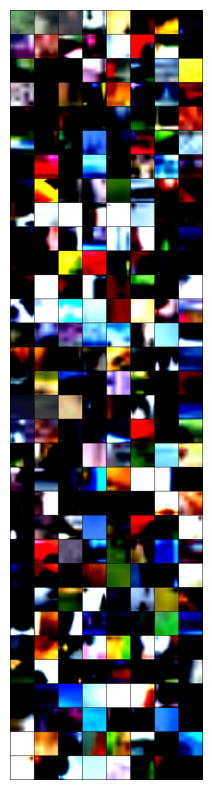

Labels: [1 4 5 5 2 7 0 3 7 6 0 6 2 7 1 4 0 3 5 6 0 5 0 0 4 7 3 0 3 7 7 6 0 4 7 6 6
 1 6 6 7 0 3 0 2 7 2 1 0 4 1 4 2 2 2 3 4 3 4 0 1 5 6 2 7 6 7 4 0 5 7 5 1 3
 6 4 5 5 5 3 2 6 7 1 0 0 2 5 7 6 7 7 6 6 4 5 1 5 2 3 2 0 6 2 1 3 6 5 6 6 7
 7 7 6 5 0 3 1 1 1 5 6 6 2 1 5 4 6]


In [10]:
example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

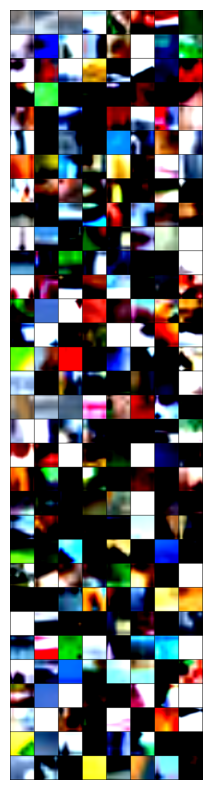

Labels: [0 4 4 1 7 5 7 7 4 5 4 5 1 0 5 2 5 0 1 1 7 1 1 5 6 6 1 2 6 4 3 0 3 3 7 7 4
 1 6 1 6 5 7 0 5 2 5 7 1 6 2 6 5 7 1 7 5 1 1 2 0 6 0 1 2 2 0 6 1 6 7 6 0 6
 6 1 3 6 7 6 3 4 3 7 6 1 6 4 4 0 1 5 4 2 3 1 3 2 2 3 2 7 0 3 3 2 1 5 5 2 0
 4 1 2 0 7 1 4 3 2 4 3 6 1 4 0 2 3]


In [11]:
##############################
# Visualizing validation dataset
##############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')

In [12]:
class AlexNetwork(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNetwork, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),

        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output


  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

model = AlexNetwork().to(device)


In [13]:
#############################################
# Initialized Optimizer, criterion, scheduler
#############################################

#optimizer = optim.Adam(model.parameters(), lr=Config.lr)
optimizer = optim.SGD(model.parameters(), Config.lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='min',
                                           patience=5,
                                           factor=0.3, verbose=True)

In [ ]:
############################
# Training/Validation Engine
############################
global_trn_loss = []
global_val_loss = []
# previous_val_loss = 100

for epoch in range(Config.num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
        uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
        loss = criterion(output, random_patch_label)
        loss.backward()
        optimizer.step()

        train_running_loss.append(loss.item())
    else:
        total=0
        correct_top1 = 0
        correct_top5 = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset) / Config.batch_size)):
            uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
            output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
            loss = criterion(output, random_patch_label)
            val_running_loss.append(loss.item())

            _, predicted_top5 = torch.topk(output.data, 5)
            _,predicted_top1 = torch.max(output.data, 1)
            total += random_patch_label.size(0)
            correct_top1 += (predicted_top1 == random_patch_label).sum()
            correct_top5 += torch.sum(predicted_top5 == random_patch_label.view(-1, 1)).item()
          print('Val Progress --- total:{}, correct top-1:{}, correct top-5:{}'.format(total, correct_top1, correct_top5))
          print('Val Accuracy (top-1) of the network on the validation set: {}%'.format(100 * correct_top1 / total))
          print('Val Accuracy (top-5) of the network on the validation set: {}%'.format(100 * correct_top5 / total))

    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    scheduler.step(global_val_loss[-1])

    print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
        epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
        (time.time() - start_time) / 60))

    if epoch % 20 == 0:
      MODEL_SAVE_PATH = f'/content/drive/MyDrive/TPssl/resultats_cifar10/model_{Config.batch_size}_{Config.num_epochs}_{Config.lr}_{Config.subset_data}_{Config.patch_dim}_{Config.gap}.pt'
      torch.save(
        {
            'epoch': Config.num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_trnloss': global_trn_loss,
            'global_valloss': global_val_loss
        }, MODEL_SAVE_PATH)


391it [05:34,  1.17it/s]
40it [00:31,  1.28it/s]                        


Val Progress --- total:5000, correct top-1:791, correct top-5:3571
Val Accuracy (top-1) of the network on the validation set: 15.819999694824219%
Val Accuracy (top-5) of the network on the validation set: 71.42%
Epoch [1/10], TRNLoss:2.0588, VALLoss:2.0436, Time:6.10


391it [05:34,  1.17it/s]
40it [00:31,  1.28it/s]                        


Val Progress --- total:5000, correct top-1:921, correct top-5:3684
Val Accuracy (top-1) of the network on the validation set: 18.420000076293945%
Val Accuracy (top-5) of the network on the validation set: 73.68%
Epoch [2/10], TRNLoss:2.0304, VALLoss:2.0167, Time:6.09


391it [05:32,  1.18it/s]
40it [00:31,  1.27it/s]                        


Val Progress --- total:5000, correct top-1:1019, correct top-5:3801
Val Accuracy (top-1) of the network on the validation set: 20.3799991607666%
Val Accuracy (top-5) of the network on the validation set: 76.02%
Epoch [3/10], TRNLoss:2.0051, VALLoss:1.9990, Time:6.07


391it [05:32,  1.18it/s]
40it [00:31,  1.27it/s]                        


Val Progress --- total:5000, correct top-1:1084, correct top-5:3933
Val Accuracy (top-1) of the network on the validation set: 21.68000030517578%
Val Accuracy (top-5) of the network on the validation set: 78.66%
Epoch [4/10], TRNLoss:1.9856, VALLoss:1.9652, Time:6.07


391it [05:35,  1.17it/s]
40it [00:32,  1.24it/s]                        


Val Progress --- total:5000, correct top-1:1140, correct top-5:3933
Val Accuracy (top-1) of the network on the validation set: 22.799999237060547%
Val Accuracy (top-5) of the network on the validation set: 78.66%
Epoch [5/10], TRNLoss:1.9592, VALLoss:1.9475, Time:6.12


391it [05:36,  1.16it/s]
40it [00:31,  1.27it/s]                        


Val Progress --- total:5000, correct top-1:1178, correct top-5:3967
Val Accuracy (top-1) of the network on the validation set: 23.559999465942383%
Val Accuracy (top-5) of the network on the validation set: 79.34%
Epoch [6/10], TRNLoss:1.9451, VALLoss:1.9415, Time:6.13


391it [05:33,  1.17it/s]
40it [00:31,  1.27it/s]


Val Progress --- total:5000, correct top-1:1195, correct top-5:3964
Val Accuracy (top-1) of the network on the validation set: 23.899999618530273%
Val Accuracy (top-5) of the network on the validation set: 79.28%
Epoch [7/10], TRNLoss:1.9337, VALLoss:1.9397, Time:6.08


391it [05:32,  1.18it/s]
40it [00:31,  1.27it/s]                        


Val Progress --- total:5000, correct top-1:1190, correct top-5:3984
Val Accuracy (top-1) of the network on the validation set: 23.799999237060547%
Val Accuracy (top-5) of the network on the validation set: 79.68%
Epoch [8/10], TRNLoss:1.9257, VALLoss:1.9359, Time:6.06


391it [05:31,  1.18it/s]
40it [00:31,  1.27it/s]                        


Val Progress --- total:5000, correct top-1:1219, correct top-5:4032
Val Accuracy (top-1) of the network on the validation set: 24.3799991607666%
Val Accuracy (top-5) of the network on the validation set: 80.64%
Epoch [9/10], TRNLoss:1.9139, VALLoss:1.9311, Time:6.05


 39%|███▊      | 151/390 [02:09<03:06,  1.28it/s]

In [14]:
testdataset = MyDataset(Config.patch_dim, Config.gap,test_data['Image'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]))
testloader = torch.utils.data.DataLoader(testdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

In [15]:
total=0
correct_top1 = 0
correct_top5 = 0
model.eval()
test_running_loss = []
global_test_loss= []
with torch.no_grad():
  for idx, data in tqdm(enumerate(testloader), total=int(len(testdataset) / Config.batch_size)):
    uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
    output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
    loss = criterion(output, random_patch_label)
    test_running_loss.append(loss.item())

    _, predicted_top5 = torch.topk(output.data, 5)
    _,predicted_top1 = torch.max(output.data, 1)
    total += random_patch_label.size(0)
    correct_top1 += (predicted_top1 == random_patch_label).sum()
    correct_top5 += torch.sum(predicted_top5 == random_patch_label.view(-1, 1)).item()
  print('Val Progress --- total:{}, correct top-1:{}, correct top-5:{}'.format(total, correct_top1, correct_top5))
  print('Val Accuracy (top-1) of the network on the test set: {}%'.format(100 * correct_top1 / total))
  print('Val Accuracy (top-5) of the network on the testset: {}%'.format(100 * correct_top5 / total))

global_test_loss.append(sum(test_running_loss) / len(test_running_loss))

scheduler.step(global_test_loss[-1])


40it [00:38,  1.04it/s]

Val Progress --- total:5000, correct top-1:639, correct top-5:3157
Val Accuracy (top-1) of the network on the test set: 12.779999732971191%
Val Accuracy (top-5) of the network on the testset: 63.14%
